## 1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

### Выбрана сверточная нейронная сеть и датасет oxford_flowers102

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

In [60]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# keras.losses.SparseCategoricalCrossentropy()
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
# tensorflow.keras.metrics.accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import shap

In [17]:
ds_name = 'oxford_flowers102'
# splits = ['test', 'validation', 'train']
splits = ['train[:30%]','test[:10%]']

dataset, info = tfds.load(ds_name, split = splits, with_info=True) #, as_supervised=True)

In [18]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [19]:
def normalize_c(input_image, label):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #label -= 1
  return input_image, label

In [20]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128))
  label = datapoint['label']

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)


  input_image, label = normalize_c(input_image, label)

  return input_image, label

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = label = datapoint['label']

  input_image, label = normalize_c(input_image, label)

  return input_image, label 

In [21]:
dataset[0]

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64}>

In [31]:
(train_examples, test_examples) = dataset

In [32]:
train = train_examples.map(load_image_train)
test = test_examples.map(load_image_test)

In [33]:
num_classes = info.features['label'].num_classes

print(f"Number of flower types {num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

# print('Flower types full list:')
classes = info.features['label'].names
print(info.features['label'].names)

Number of flower types 102
Number of training examples: 306
Number of test examples: 615

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargoniu

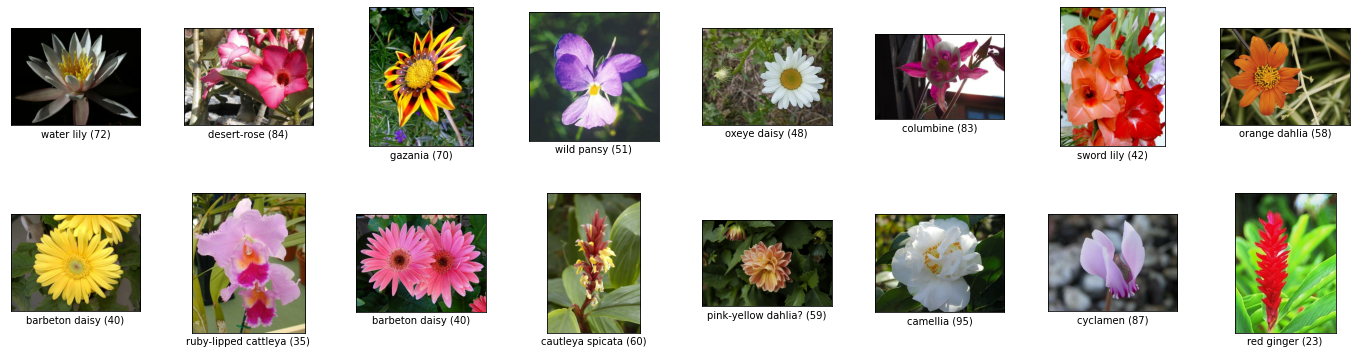

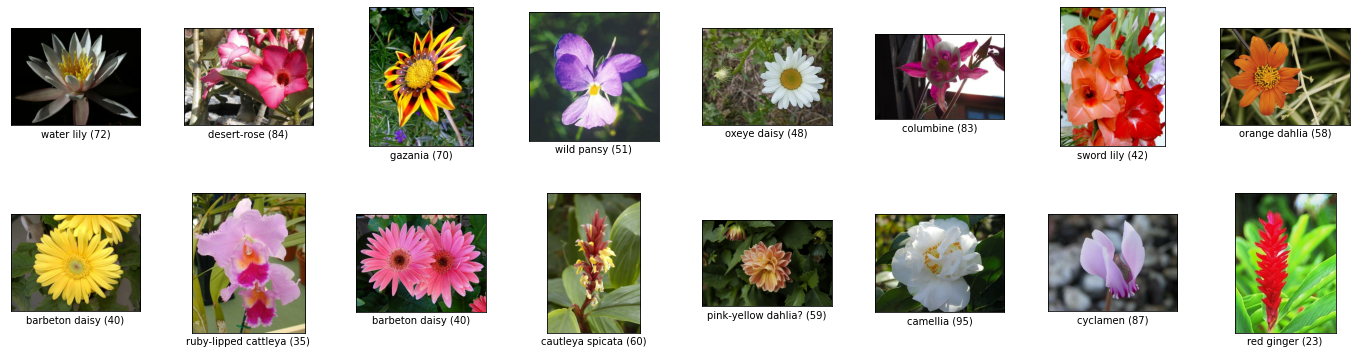

In [34]:
tfds.show_examples(train_examples, info, rows=2, cols=8)

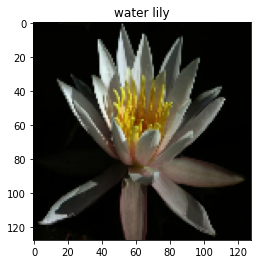

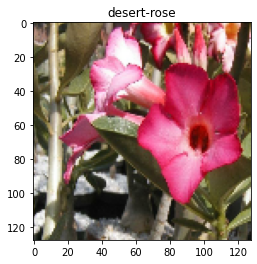

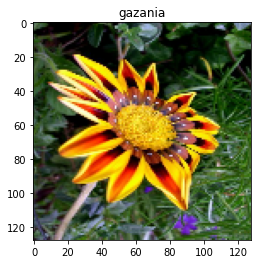

In [36]:
for image, label in train.take(3):
  sample_image, sample_label = image, label
  plt.imshow(sample_image.numpy()[:,:,:])
  plt.title(classes[sample_label.numpy()])
  plt.show()

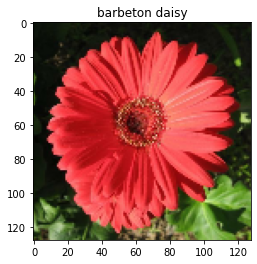

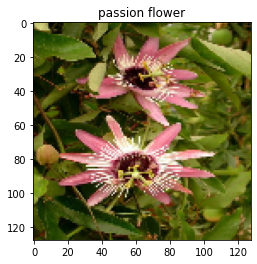

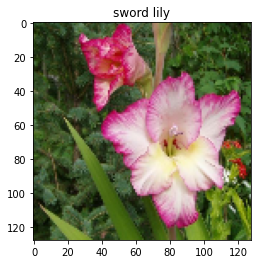

In [37]:
for image, label in test.take(3):
  sample_image, sample_label = image, label
  plt.imshow(sample_image.numpy()[:,:,:])
  plt.title(classes[sample_label.numpy()])
  plt.show()

### Соберем сеть как на занятии

In [38]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [39]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train.batch(BATCH_SIZE)

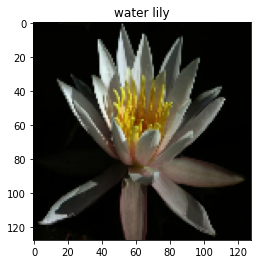

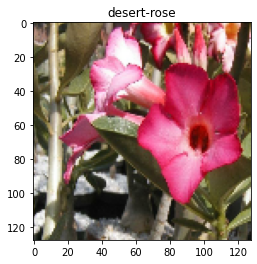

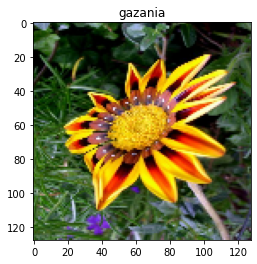

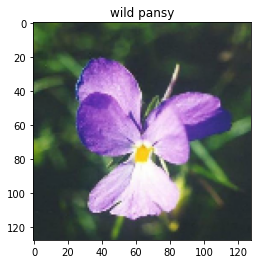

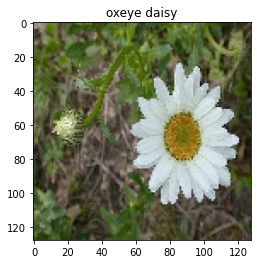

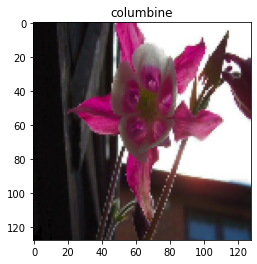

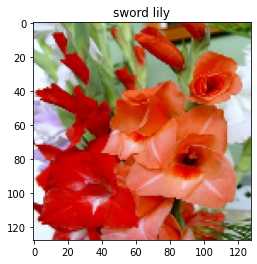

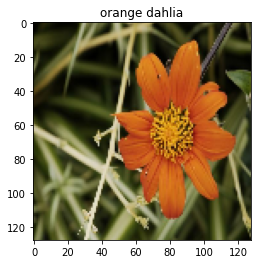

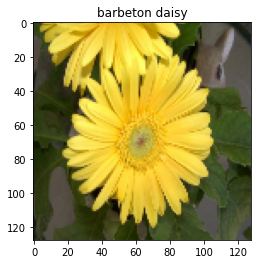

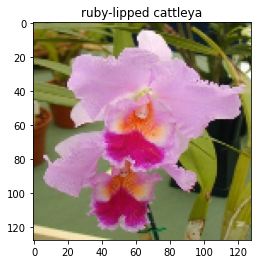

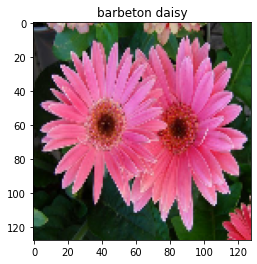

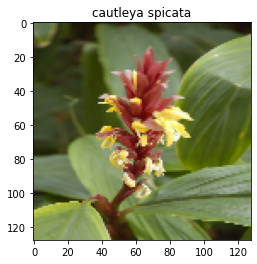

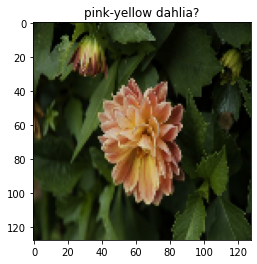

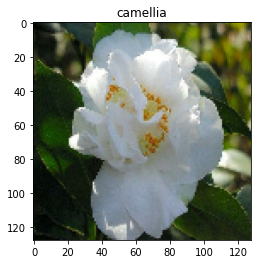

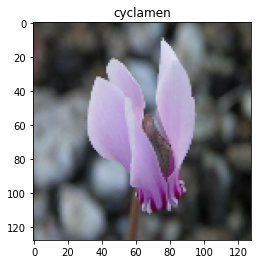

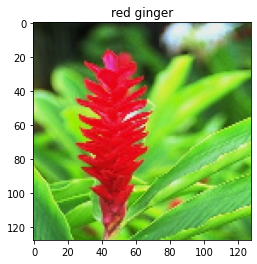

In [40]:
for image, label in train_dataset.take(1):
  
  sample_image, sample_label = image, label
  for i in range(BATCH_SIZE):
    plt.imshow(sample_image.numpy()[i,:,:,:])
    plt.title(classes[sample_label.numpy()[i]])
    plt.show()

### Аугментация

In [42]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=90, # очень много - это для демнонстрации
        width_shift_range=0.5,  # очень много - это для демнонстрации
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [43]:
g = tfds.as_numpy((train_dataset.take(10)))
for x,y in g:
  datagen.fit(x)

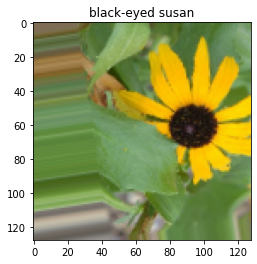

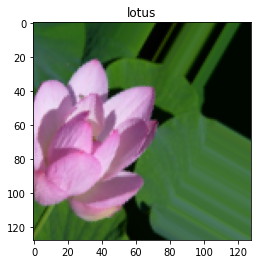

In [64]:
N=1
for image,label in datagen.flow(x,y, batch_size=2):
    for i in range(2):
      plt.imshow(image[i,:,:,:])
      plt.title(classes[label[i]])
      plt.show()
    break

In [65]:
image_size = (image.shape[1], image.shape[2], image.shape[3])
name='flower_model'

In [67]:
# конфигурирование слоев нейросети

model = Sequential(name=name)

model.add(Conv2D(32, (3, 3), padding='same', strides=2, input_shape=image_size))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [68]:
model.summary()

Model: "flower_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 31, 64)       

In [69]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [129]:
history = model.fit(train_dataset, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
20/20 [==============================] - 3s 124ms/step - loss: 0.2357 - accuracy: 0.9281
Epoch 2/15
20/20 [==============================] - 3s 131ms/step - loss: 0.2501 - accuracy: 0.9346
Epoch 3/15
20/20 [==============================] - 2s 121ms/step - loss: 0.2061 - accuracy: 0.9379
Epoch 4/15
20/20 [==============================] - 2s 122ms/step - loss: 0.2248 - accuracy: 0.9281
Epoch 5/15
20/20 [==============================] - 2s 122ms/step - loss: 0.1429 - accuracy: 0.9477
Epoch 6/15
20/20 [==============================] - 3s 133ms/step - loss: 0.2361 - accuracy: 0.9346
Epoch 7/15
20/20 [==============================] - 3s 126ms/step - loss: 0.1942 - accuracy: 0.9477
Epoch 8/15
20/20 [==============================] - 3s 126ms/step - loss: 0.2802 - accuracy: 0.9379
Epoch 9/15
20/20 [==============================] - 3s 136ms/step - loss: 0.1726 - accuracy: 0.9510
Epoch 10/15
20/20 [==============================] - 3s 156ms/step - loss: 0.1769 - accuracy: 0.9641

In [ ]:
# сохранение модели и весов
save_dir = '/home/mitko/Projects/Neural_networks/lesson8'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, name)
model.save(model_path)
print('Cохранить обученную модель как %s ' % model_path)

INFO:tensorflow:Assets written to: /home/mitko/Projects/Neural_networks/lesson8/flower_model/assets


INFO:tensorflow:Assets written to: /home/mitko/Projects/Neural_networks/lesson8/flower_model/assets


Cохранить обученную модель как /home/mitko/Projects/Neural_networks/lesson8/flower_model 


In [ ]:
print(history.history)

{'loss': [0.23565421998500824, 0.25007176399230957, 0.20608104765415192, 0.22476673126220703, 0.14293816685676575, 0.23607316613197327, 0.1942179799079895, 0.2801871597766876, 0.17258280515670776, 0.17693884670734406, 0.18212154507637024, 0.11797221750020981, 0.07268757373094559, 0.1396782398223877, 0.11733134835958481], 'accuracy': [0.9281045794487, 0.9346405267715454, 0.9379084706306458, 0.9281045794487, 0.9477124214172363, 0.9346405267715454, 0.9477124214172363, 0.9379084706306458, 0.9509803652763367, 0.9640522599220276, 0.9575163125991821, 0.9673202633857727, 0.970588207244873, 0.9477124214172363, 0.9575163125991821]}


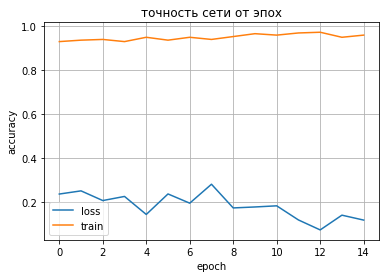

In [ ]:
plt.plot(history.history['loss'] ,label='loss')
plt.plot(history.history['accuracy'] ,label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('точность сети от эпох')
plt.grid()
plt.show()

### Оценка обучения

### Вообще не поняла, как работает shap_value, потому что возникает ошибка "AttributeError: module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'"

In [81]:
# берем примеров для оценки


background = x_test[np.random.choice(x_test.shape[0], 10, replace=False)]

# объясняем через  model наши   images
# e = shap.DeepExplainer(model, background)
# можно подать прямо в модель
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

In [103]:
# shap_values = e.shap_values(x_test[:1])

In [ ]:
# i_image  = 0
# shap.image_plot(shap_values[y_label[i_image]], x_test[i_image:i_image+1])

In [ ]:
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(x_test[1:5])

# # plot 
# shap.image_plot(shap_values, x_test[1:5])

### Проверка работы обученной модели

Сделаем предикт для примеров тестов

[72 84 70 51 48 83 42 58 40 35 40 60 59 95 87 23]
true label - 72
predicted label - 72


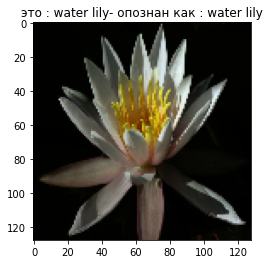

true label - 84
predicted label - 84


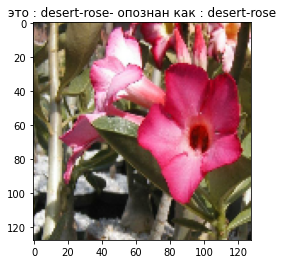

true label - 70
predicted label - 70


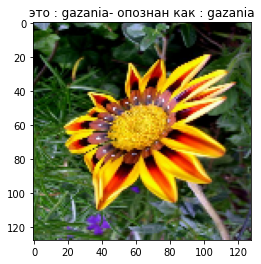

In [169]:
N = 3
for image, label in train_dataset.take(1):
    
    image, label = image.numpy(), label.numpy()
    print(label)
    
    for i in range(N):
        y_p=model.predict(image[i:i+1][:,:,:])
#         print(y_p)
        y_t = label[i:i+1]
        print(f'true label - {y_t[0]}')
        y_i = np.argmax(y_p, axis = 1)
        print(f'predicted label - {y_i[0]}')
        plt.imshow(image[i][:,:,:])
        plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
        plt.show()

## 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 